In [1]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.


In [2]:
from scipy.fftpack import dct
from scipy.stats import zscore
from math import sqrt

In [3]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('speech_files/')
dir_list.sort()
dir_list.remove('.DS_Store')
#print (dir_list)

In [4]:
len(dir_list)

151

In [5]:
emo_list = os.listdir('labels/')
emo_list.sort()
emo_list.remove('.ipynb_checkpoints')
print(len(emo_list))

151


In [6]:
emotions = ['neu','ang','fru','hap','sur','exc','sad','fea','dis','xxx','oth']
emo_df = pd.DataFrame(columns=['time', 'actors', 'emotions', 'v-a-d'])
count = 0
for f in emo_list:
    df = pd.read_table('labels/'+f, names = ['time','actors','emotions','v-a-d']) #read label files 
    emo_df = emo_df.append(df.loc[df['emotions'].isin(emotions)]) #keep only those rwos that have averaged labels
emo_df = emo_df.reset_index(drop=True)

In [7]:
annotations = pd.DataFrame(columns=['time', 'actors', 'emotions', 'v-a-d']) #new dataframe to store all annotations


for f in emo_list:
    df = pd.read_table('labels/'+f, names = ['time','actors','emotions','v-a-d'])
    for i in range(len(df)):
        if(df.at[i,'time'][0]=='A'): #to keep only annotations starting with A - attribute evaluators
            annotations = annotations.append(df.loc[i])


In [8]:
annotations = annotations.reset_index()

In [7]:
emo_df

,time,actors,emotions,v-a-d
0,[6.2901 - 8.2357],Ses01F_impro01_F000,neu,"[2.5000, 2.5000, 2.5000]"
1,[10.0100 - 11.3925],Ses01F_impro01_F001,neu,"[2.5000, 2.5000, 2.5000]"
2,[14.8872 - 18.0175],Ses01F_impro01_F002,neu,"[2.5000, 2.5000, 2.5000]"
3,[19.2900 - 20.7875],Ses01F_impro01_F003,xxx,"[2.5000, 3.0000, 3.0000]"
4,[21.3257 - 24.7400],Ses01F_impro01_F004,xxx,"[2.5000, 3.0000, 2.5000]"
...,...,...,...,...
10034,[236.5700 - 244.8300],Ses05M_script03_2_M041,ang,"[1.0000, 4.5000, 5.0000]"
10035,[244.8400 - 246.5800],Ses05M_script03_2_M042,ang,"[1.0000, 4.5000, 4.5000]"
10036,[246.5900 - 248.8300],Ses05M_script03_2_M043,ang,"[1.5000, 4.0000, 4.5000]"
10037,[255.8600 - 260.3300],Ses05M_script03_2_M044,ang,"[1.0000, 5.0000, 5.0000]"


In [37]:
annotations.at[0,'actors'][11]

'2'

In [9]:
emo1 = pd.DataFrame(columns=['valence1','activation1']) #to store average of all annotations
vals = []
acts = []
j=0
for i in range(len(annotations)):
    ind = annotations.at[i,'index']
    if (i==0 or ind == (ind_pre+1)):
        vals.append(int(annotations.at[i,'actors'][4])) #valence
        acts.append(int(annotations.at[i,'actors'][11])) #activation
        ind_pre = ind
    else: 
        val = sum(vals)/len(vals)
        act = sum(acts)/len(acts)
        emo1.at[j,'valence1'] = val
        emo1.at[j,'activation1'] = act
        j=j+1
        vals=[]
        acts=[]
        vals.append(int(annotations.at[i,'actors'][4]))
        acts.append(int(annotations.at[i,'actors'][11]))
        ind_pre = ind
    if(i==(len(annotations)-1)):
        val = sum(vals)/len(vals)
        act = sum(acts)/len(acts)
        emo1.at[j,'valence1'] = val
        emo1.at[j,'activation1'] = act

In [21]:
emo1

,valence1,activation1
0,2.66667,2.33333
1,2.33333,2.66667
2,2.66667,2.66667
3,2.33333,3
4,2.66667,3.33333
...,...,...
10034,1,4.5
10035,1,4.5
10036,1.5,4
10037,1,5


In [38]:
float(emo_df.at[0,'v-a-d'][9:15])

2.5

In [12]:
emo_df.groupby('emotions').count()

,time,actors,v-a-d
emotions,,,
ang,1103,1103,1103
dis,2,2,2
exc,1041,1041,1041
fea,40,40,40
fru,1849,1849,1849
hap,595,595,595
neu,1708,1708,1708
oth,3,3,3
sad,1084,1084,1084


In [10]:
data_df = pd.DataFrame(columns=['path', 'actor', 'gender', 'emotion','valence','activation','logfb','mfb'])
count = 0
actors=[]
for i in dir_list:
    file_list = os.listdir('speech_files/' + i) #list of directories within speech files
    file_list.sort()
    
    for f in file_list:
        if (f[-1]!='k'): #remove .pk files
            if (f!='.DS_Store'):
                path = 'speech_files/' + i + '/' + f #file within one session eg: f = Ses01F_impro01_F000.wav 
                actor = f[-8]+f[3:5] #(F000.wav+Ses01)
                gender = f[-8] 
                if (f[:-4]==emo_df.at[count,'actors']): #check if we are in correct row of emo_df 
                    emotion = emo_df.at[count,'emotions']
                    valence = float(emo_df.at[count,'v-a-d'][1:7])
                    if (valence>=1 and valence<=2.75):
                        valence = 'low'
                    elif (valence<=3.25):
                        valence='mid'
                    else:
                        valence='high'
                    activation=float(emo_df.at[count,'v-a-d'][9:15])
                    if (activation>=1 and activation<=2.75):
                        activation = 'low'
                    elif (activation<=3.25):
                        activation='mid'
                    else:
                        activation='high'
                    #valence1 = emo1.at[count,'valence1']
                    #if (valence1>=1 and valence1<=2.75):
                     #   valence1 = 'low'
                    #elif (valence1<=3.25):
                     #   valence1='mid'
                    #else:
                     #   valence1='high'
                    #activation1= emo1.at[count,'activation1']
                    #if (activation1>=1 and activation1<=2.75):
                     #   activation1 = 'low'
                    #elif (activation1<=3.25):
                     #   activation1='mid'
                    #else:
                     #   activation1='high'    
                actors.append(f)
                data_df.loc[count] = [path, actor, gender, emotion, valence, activation,0,0]
                count=count+1


In [11]:
grouped = data_df.groupby(['emotion', 'gender'])

In [16]:
#number of actors
len(np.unique(data_df.actor)) 

10

In [ ]:
filename = ''

In [17]:
scipy_sampling_rate, scipy_load = wavfile.read(data_df.path[0])
scipy_sampling_rate, scipy_load

(16000, array([-165, -163, -125, ...,  -87, -104, -137], dtype=int16))

In [25]:
scipy_load.shape

(31129,)

In [ ]:
scipy_load.shape[0]/16000
time = np.arange(0, float(scipy_load.shape[0]), 1) / scipy_sampling_rate

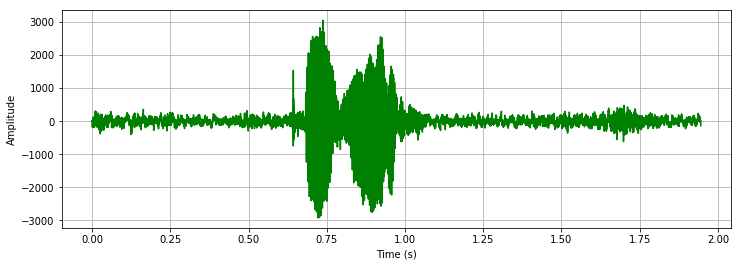

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(time, scipy_load,'g')# linewidth=0.01, alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

In [36]:
time = np.linspace(0.75,0.775,400)

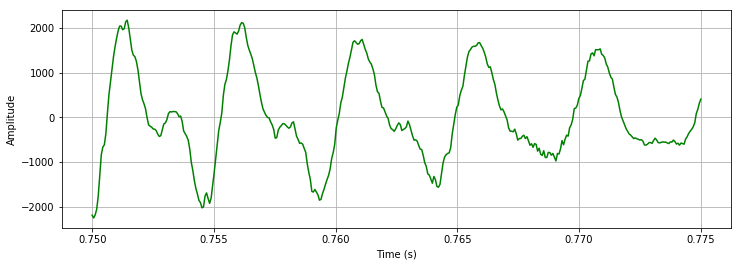

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(time, scipy_load[12000:12400],'g')# linewidth=0.01, alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

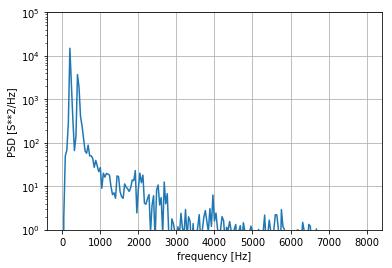

In [43]:
f, Pxx_den = signal.periodogram(scipy_load[12000:12400], scipy_sampling_rate)
plt.semilogy(f, Pxx_den)
plt.ylim([1e0, 1e5])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [S**2/Hz]')
plt.grid(True)
plt.show()

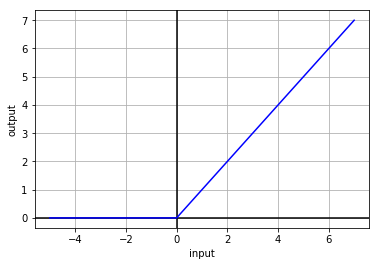

In [47]:
x = [-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]
y = [0,0,0,0,0,0,1,2,3,4,5,6,7]
plt.xlabel('input')
plt.ylabel('output')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(x,y,'b')
plt.grid(True)
plt.show()

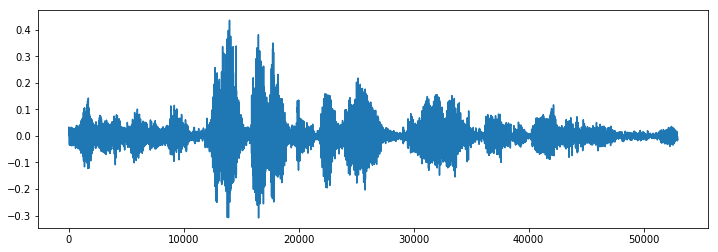

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(samples)

In [12]:
#dataframe to store MFB 
data = pd.DataFrame(columns=['MFB_var'])

In [264]:
''''pre_emphasis = 0.97
frame_size = 0.025
frame_stride = 0.01
nfilt = 40
NFFT = 512
i=0
while i<1:
    sample_rate, signal = scipy.io.wavfile.read(data_df.path[i])  # File assumed to be in the same directory
    #print(sample_rate)
    #signal = signal[0:int(4.5 * sample_rate)]  # Keep the first 3.5 seconds
    length = len(signal)
    #signal = np.append(signal,np.zeros(int(4.5*sample_rate)-length))
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    #print(signal_length)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    #pad_signal_length = num_frames * frame_step + frame_length
    #z = np.zeros((pad_signal_length - signal_length))
    #print(len(z))
    #pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    #print(len(pad_signal))
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = emphasized_signal[indices.astype(np.int32, copy=False)]
    #frames *= np.hamming(frame_length)
    frames *= scipy.signal.windows.hamming(frame_length)
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    low_freq_mel = (2595 * np.log10(1 + (0 / 2) / 700))
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    #filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    #data.loc[i] = [filter_banks]'''
    #i+=1

In [ ]:
def preemphasis(signal,coeff):
    return numpy.append(signal[0],signal[1:]-signal[:-1]*coeff)

In [ ]:
sample_rate, signal = wavfile.read(data_df.path[0])
import python_speech_features
from python_speech_features import fbank
from python_speech_features import logfbank

 #doubts - fmin, preemph or not?, log output?


mfb = fbank(signal, samplerate=16000, winlen=0.025, winstep=0.01,
      nfilt=40, nfft=512,lowfreq=0,highfreq=None,preemph=0.97) #doubts - fmin, preemph or not?, log output?


In [ ]:
filter_banks=np.transpose(S)
filter_banks = 20 * np.log10(filter_banks)
#filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

filter_banks


In [ ]:
#list of audio samples 
audio_samples = []
srate = []
for i in tqdm(range(len(data_df))):
    sample_rate, samples = wavfile.read(data_df.path[i])
    audio_samples.append(samples)
    srate.append(sample_rate)

In [299]:
np.unique(srate)

array([16000])

In [300]:
sample_lengths = []

In [301]:
for i in tqdm(range(len(audio_samples))):
    sample_lengths.append(len(audio_samples[i]))

100%|██████████| 10039/10039 [00:00<00:00, 41705.08it/s]


In [225]:
pad = int(round(np.percentile(sample_lengths,50)))

In [226]:
pad

56319

In [302]:
pad = int(np.nanmean(sample_lengths))

In [228]:
np.std(sample_lengths)

49032.372366776

In [25]:
type(audio_samples[0][0])

numpy.int16

In [303]:
#librosa mfb
''''sr = sample_rate #16000 
n_fft=512
win_length = 400 #25ms
hop_length = 160 #10ms 
n_mels = 40 
for i in tqdm(range(len(data_df))):
    sample = audio_samples[i]
    sample=preemphasis(sample,0.97)
    #if(len(sample)>=pad):
        #sample_e = sample[0:pad] #truncating to mena length
    #else:
        #z = np.zeros((int(pad) - len(sample)))
        #sample_e = np.append(z,sample) #padding to mean length
        #print(len(sample_e))
    
    S_var = librosa.feature.melspectrogram(sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, 
                                           n_mels=n_mels,window =scipy.signal.windows.hamming,
                                           win_length=win_length, fmin=300) #variable length
    #S_eq = librosa.feature.melspectrogram(sample_e, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, 
                                          #n_mels=n_mels,window =scipy.signal.windows.hamming,
                                          #win_length=win_length, fmin=300) #equal length
    
    Sv_trans = np.transpose(S_var)
    Sv_fb = 20 * np.log10(Sv_trans)


    #Se_trans = np.transpose(S_eq)
    #Se_trans = np.where(Se_trans == 0, np.finfo(float).eps, Se_trans)  # Numerical Stability
    #Se_fb = 20 * np.log10(Se_trans)

    #S_trans = np.where(S_trans==0, np.NaN, S_trans)
    data['MFB_var'].loc[i] = Sv_fb
    #data['MFB_eq'].loc[i] = Se_fb

100%|██████████| 10039/10039 [01:59<00:00, 84.24it/s]


In [13]:
'''#MFB energies through python_speech_features
import python_speech_features
from python_speech_features import fbank
from python_speech_features import logfbank
for i in tqdm(range(len(data_df))):
    sample_rate, signal = wavfile.read(data_df.path[i])
    fbanks = logfbank(signal, samplerate=16000, winlen=0.025, winstep=0.01,
                  nfilt=40, nfft=512,lowfreq=0,highfreq=None,preemph=0.97)
    data_df['logfb'].loc[i] = fbanks

100%|██████████| 10039/10039 [03:12<00:00, 52.20it/s]


In [10]:
#MFB energies through python_speech_features
logfbs =[]
mfbs = []
sample_rate, signal = wavfile.read(data_df.path[0])
n_fft = int(np.ceil(sample_rate * 0.025))
import python_speech_features
from python_speech_features import fbank
from python_speech_features import logfbank
for i in tqdm(range(len(data_df))):
    sample_rate, signal = wavfile.read(data_df.path[i])
    lfbanks = logfbank(signal, samplerate = sample_rate, winlen=0.025, winstep=0.01,
                  nfilt=40, nfft = n_fft,lowfreq = 0,highfreq=None,preemph=0.97)
    fbanks = fbank(signal, samplerate=sample_rate, winlen=0.025, winstep=0.01,
                  nfilt=40, nfft=n_fft,lowfreq=0,highfreq=None,preemph=0.97)
    fbanks = fbanks[0]
    data_df['logfb'].loc[i] = lfbanks
    data_df['mfb'].loc[i] = fbanks

100%|██████████| 10039/10039 [09:16<00:00, 18.04it/s]


In [ ]:
data_df['MFB_var']
#data_df['MFB_eq']=data['MFB_eq']

In [11]:
data_df = data_df.sort_values('actor')

In [12]:
data_df=data_df.reset_index(drop=True)

In [18]:
actor_groupby = data_df.groupby(['actor'])

In [309]:
actor_groupby.count()

,path,gender,emotion,valence,activation,valence1,activation1,MFB_var,MFB_eq
actor,,,,,,,,,
F01,873,873,873,873,873,873,873,873,873
F02,859,859,859,859,859,859,859,859,859
F03,1048,1048,1048,1048,1048,1048,1048,1048,1048
F04,987,987,987,987,987,987,987,987,987
F05,1033,1033,1033,1033,1033,1033,1033,1033,1033
M01,946,946,946,946,946,946,946,946,946
M02,952,952,952,952,952,952,952,952,952
M03,1088,1088,1088,1088,1088,1088,1088,1088,1088
M04,1116,1116,1116,1116,1116,1116,1116,1116,1116


In [19]:
number = actor_groupby.size()

In [38]:
number

actor
F01     873
F02     859
F03    1048
F04     987
F05    1033
M01     946
M02     952
M03    1088
M04    1116
M05    1137
dtype: int64

In [ ]:
#mean and std.dev by feature by actor
'''count = 0
k=0
means=[]
sds=[]
X=[]
for num in number:
    X=[]
    for i in range(num):
        for j in range(len(data_df['MFB'][i+k])):
            X.append(data_df['MFB'][i+k][j])
    print(i+k)
    mean = np.mean(X,axis=0)
    sd = np.std(X,axis=0)
    means.append(mean)
    sds.append(sd)
    k=num+k
    count+=1
        


In [47]:
#norm by feature by actor
'''count = 0
#data_norm = pd.DataFrame(columns=['norm'])
norm1 =[]
norm2 = []
k=0
for num in tqdm(number):
    for i in range(num):
        norm1=[]
        for j in range(len(data_df['MFB'][i+k])):
            x = data_df['MFB'][i+k][j]- means[count]
            y = np.divide(x,sds[count])
            norm1.append(y)
        norm2.append(norm1)
    count+=1
    k=num+i

100%|██████████| 10/10 [02:20<00:00, 14.01s/it]


In [110]:
#feature_mean_1 = actor_feature.MFB.apply(lambda x: np.mean(x,axis=1))

In [43]:
#mean and std.dev by actor 
count = 0 #keeps count of actor number
k=0 # keeps count of index number
mean_1=[] 
sd_1=[]
mean_2=[]
sd_2=[]
X=[] #list that has all frames belonging to one actor 
for num in number:
    Xv=[]
    Xe=[]
    for i in range(num):
        for j in range(len(data_df['MFB_var'][i+k])):
            Xv.append(data_df['MFB_var'][i+k][j])
        #for j in range(len(data_df['MFB_eq'][i+k])):
            #Xe.append(data_df['MFB_eq'][i+k][j])
    print(i+k)
    mean1 = np.mean(Xv)
    sdv1 = np.std(Xv)
    mean2 = np.mean(Xv, axis=0)
    sdv2 = np.std(Xv,axis=0 )
    #meane = np.mean(Xe)
    #sde = np.std(Xe)
    mean_1.append(mean1)
    sd_1.append(sdv1)
    mean_2.append(mean2)
    sd_2.append(sdv2)
    #mean_eq.append(meane)
    #sd_eq.append(sde)
    k=num+k
    count+=1
        

872
1731
2779
3766
4799
5745
6697
7785
8901
10038


In [45]:
mean_v=np.zeros((10,40))
sd_v=np.zeros((10,40))
#mean_e=np.zeros((10,40))
#sd_e=np.zeros((10,40))
for i in range(10):
    for j in range(40):
        mean_v[i][j]=mean_1[i]
        sd_v[i][j]=sd_1[i]
        #mean_e[i][j]=mean_eq[i]
        #sd_e[i][j]=sd_eq[i]

In [50]:
# normalise over actors
count = 0
#data_norm = pd.DataFrame(columns=['norm'])
norm2v =[]
norm2e = []
k=0
for num in tqdm(number):
    for i in range(num):
        norm1v=[]
        norm1e=[]
        for j in range(len(data_df['MFB_var'][i+k])):
            xv = data_df['MFB_var'][i+k][j]- mean_v[count]
            yv = np.divide(xv,sd_v[count])
            norm1v.append(yv)
      
            xe = data_df['MFB_var'][i+k][j]- mean_2[count]
            ye = np.divide(xe,sd_2[count])
            norm1e.append(ye)
        norm2v.append(norm1v)
        norm2e.append(norm1e)
    count+=1
    k=num+i

100%|██████████| 10/10 [04:46<00:00, 28.66s/it]


In [55]:
len(norm2e[0][0])

40

In [57]:
data_df['norm_var']=norm2v
data_df['norm_af']=norm2e

In [ ]:
data_df['norm_var'].to_pickle('norm_act.pkl')
data_df['norm_af'].to_pickle('norm_acfe.pkl')

In [345]:
# break up feature file in sets of 500..total 20 pkl files 
count=0
for i in range(20):
    if (i!=19):
        feat = data_df['norm_var'][count:count+500]
        feat.to_pickle('norm_var1%s.pkl'%(i+1))
    else:
        feat=data_df['norm_var'][count:10039]
        feat.to_pickle('norm_var1%s.pkl'%20)
    count+=500



In [83]:
# break up feature file in sets of 500..total 20 pkl files 
count=0
for i in range(20):
    if (i!=19):
        feat1 = data_df['norm_eq'][count:count+500]
        feat1.to_pickle('norm_eq%s.pkl'%(i+1))
    else:
        feat1=data_df['norm_eq'][count:10039]
        feat1.to_pickle('norm_eq%s.pkl'%20)
    count+=500



In [346]:
# break up feature file in sets of 500..total 20 pkl files 
count=0
for i in range(20):
    if (i!=19):
        feat1 = data_df['MFB_var'][count:count+500]
        feat1.to_pickle('MFB_psf%s.pkl'%(i+1))
    else:
        feat1=data_df['MFB_var'][count:10039]
        feat1.to_pickle('MFB_psf%s.pkl'%20)
    count+=500



In [15]:
data_df.to_pickle('IEMO_data.pkl')

In [86]:
# break up feature file in sets of 500..total 20 pkl files 
count=0
for i in range(20):
    if (i!=19):
        feat1 = data_df['MFB_eq'][count:count+500]
        feat1.to_pickle('MFB_eq%s.pkl'%(i+1))
    else:
        feat1=data_df['MFB_eq'][count:10039]
        feat1.to_pickle('MFB_eq%s.pkl'%20)
    count+=500

In [ ]:
'''count = 0
prev = 0
tot = np.zeros((689,40))
std = []
for num in number:
    for i in range(num):   #sqrt(mean(abs(x - x.mean())**2))
        tot += abs(data_df.MFB[i+prev]-feature_mean[count])**2
    std.append(np.sqrt((tot)/(num-1)))
    count+=1
    print(prev+i)
    prev = prev + num

In [164]:
'''count = 0
prev = 0
data_df['normalized'] = data_df['MFB']
for num in number:
    for i in range(num):   #sqrt(mean(abs(x - x.mean())**2))
        data_df['normalized'][i+prev] = (data_df.MFB[i+prev]-feature_mean[count])/std[count]
    count+=1
    prev = prev + num

In [168]:
'''for i in range(len(data_df)):
    data_df['normalized'][i] = np.where(np.isnan(data_df['normalized'][i]), 0, data_df['normalized'][i])



In [347]:
data_df_copy = data_df

In [348]:
data_df.drop('norm_var',axis=1,inplace=True )

In [349]:
data_df.drop('MFB_var',axis=1,inplace=True )

In [350]:
data_df.drop('MFB_eq',axis=1,inplace=True)

In [91]:
data_df.drop('norm_eq',axis=1,inplace=True)

In [351]:
data_df.head()

,path,actor,gender,emotion,valence,activation,valence1,activation1
0,speech_files/Ses01F_impro01/Ses01F_impro01_F00...,F01,F,neu,low,low,low,low
1,speech_files/Ses01M_impro01/Ses01M_impro01_F00...,F01,F,xxx,mid,mid,low,mid
2,speech_files/Ses01F_impro07/Ses01F_impro07_F00...,F01,F,xxx,high,high,high,high
3,speech_files/Ses01F_impro06/Ses01F_impro06_F01...,F01,F,neu,low,low,low,low
4,speech_files/Ses01F_impro06/Ses01F_impro06_F02...,F01,F,sad,low,mid,low,mid


In [352]:
data_df.to_excel('data_dropped1.xlsx')

In [353]:
data_df_copy.to_excel('data_var_eq1.xlsx')

In [42]:
# break up feature file in sets of 500..total 20 pkl files 
'''count=0
for i in range(18):
    if (i!=17):
        feat = data_df['norm'][count:count+500]
        feat.to_pickle('feature_nan%s.pkl'%(i+1))
    else:
        feat=data_df['norm'][count:9156]
        feat.to_pickle('feature_nan%s.pkl'%18)
    count+=500
